# Estimation of weed growth

In this project, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You can use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

## Part 0. Data Preparation

The data for this project are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> 

There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Visualize five images from the dataset.</li>
</ul>


In [ ]:
from zipfile import ZipFile
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import skimage.io
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from skimage.io import imread
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator

import glob

import os

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.applications.vgg16 import VGG16
from  keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,InputLayer,BatchNormalizationV2,Activation

import PIL
import pathlib
import cv2

from tqdm import tqdm
from tqdm import trange
from tqdm.notebook import tqdm_notebook
import time

import numpy as np

import random

np.random.seed(45)
tf.random.set_seed(45)

In [ ]:
from google.colab import drive# from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/cv ass 3/training/',
    validation_split=0.1111111111111111111,
    subset = 'training',
    batch_size=32,
    seed = 42,
    image_size=(64, 64))
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/cv ass 3/training/',
    validation_split=0.1111111111111111111,
    subset = 'validation',
    batch_size=32,
    seed = 42,
    image_size=(64, 64))
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/cv ass 3/testing/',
    batch_size=32,
    seed = 42,
    image_size=(64, 64))

Found 900 files belonging to 5 classes.
Using 800 files for training.
Found 900 files belonging to 5 classes.
Using 100 files for validation.
Found 100 files belonging to 5 classes.


In [ ]:
x_train = np.concatenate([x for x,y in train_ds],axis=0)
y_train  = np.concatenate([y for x,y in train_ds],axis=0)

In [ ]:
x_val = np.concatenate([x for x,y in validation_ds],axis=0)
y_val  = np.concatenate([y for x,y in validation_ds],axis=0)

In [ ]:
x_test = np.concatenate([x for x,y in test_ds],axis=0)
y_test  = np.concatenate([y for x,y in test_ds],axis=0)

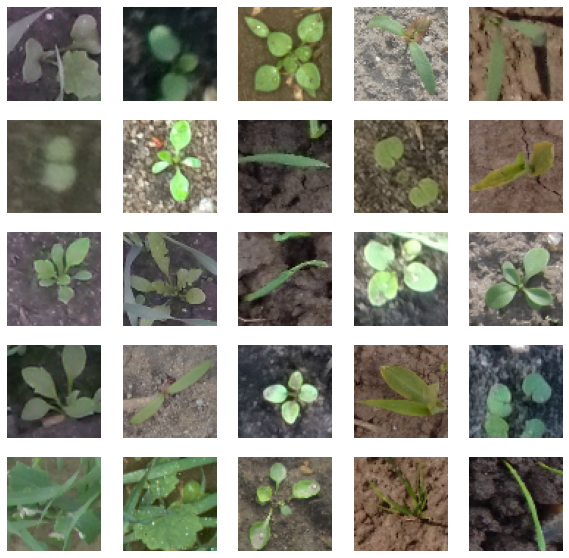

In [ ]:
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title("Number of leafs: "+ labels[i])
        plt.axis("off")

## Part 1a. Transfer Learning - Classification Network
For this project, you are going to use Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [ ]:
VGG_model = VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))
VGG_model.trainable = False
VGG_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
VGG_model.layers

In [ ]:
custom_vgg = VGG_model.layers[6].output
custom_vgg = Flatten()(custom_vgg)
custom_vgg = Dense(1024, activation = 'relu')(custom_vgg)
custom_vgg = Dense(512, activation = 'relu')(custom_vgg)
custom_vgg = Dense(256, activation = 'relu')(custom_vgg)
custom_vgg = Dense(128, activation = 'relu')(custom_vgg)
custom_vgg = Dense(32, activation = 'relu')(custom_vgg)



output_layer = Dense(len(class_names), activation='softmax')(custom_vgg)

custom_vgg_model = Model(inputs=VGG_model.input, outputs=output_layer)

custom_vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

model_result = custom_vgg_model.fit(
    train_ds,
    epochs=30,
    validation_data=(validation_ds)
    
    )


custom_vgg_model.summary()

Epoch 1/30
25/25 [==============================] - 10s 83ms/step - loss: 6062.1836 - accuracy: 0.2338 - val_loss: 1541.4999 - val_accuracy: 0.2300
Epoch 2/30
25/25 [==============================] - 2s 73ms/step - loss: 1447.9259 - accuracy: 0.2113 - val_loss: 1775.7688 - val_accuracy: 0.1900
Epoch 3/30
25/25 [==============================] - 2s 73ms/step - loss: 1005.8954 - accuracy: 0.2150 - val_loss: 820.3816 - val_accuracy: 0.1900
Epoch 4/30
25/25 [==============================] - 2s 73ms/step - loss: 197.3250 - accuracy: 0.2537 - val_loss: 1.6093 - val_accuracy: 0.2100
Epoch 5/30
25/25 [==============================] - 3s 77ms/step - loss: 1.6101 - accuracy: 0.1988 - val_loss: 1.6093 - val_accuracy: 0.2100
Epoch 6/30
25/25 [==============================] - 2s 74ms/step - loss: 1.6522 - accuracy: 0.1975 - val_loss: 1.6093 - val_accuracy: 0.2100
Epoch 7/30
25/25 [==============================] - 2s 73ms/step - loss: 1.6095 - accuracy: 0.1988 - val_loss: 1.6094 - val_accuracy: 

In [ ]:
def loss_plot (M):
    plt.plot(M.history['loss'])
    plt.plot(M.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss');
    plt.xlabel('epoch');
    plt.legend(['train', 'val']);

In [ ]:
def accuracy_plot (M):
    plt.plot(M.history['accuracy'])
    plt.plot(M.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy');
    plt.xlabel('epoch');
    plt.legend(['train', 'val']);

Loss curves of model 1: 


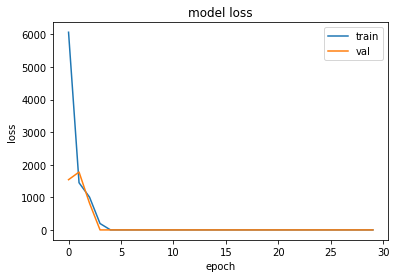

In [ ]:
print("Loss curves of model 1: ")
loss_plot(model_result)

Accuracy curves of model 1: 


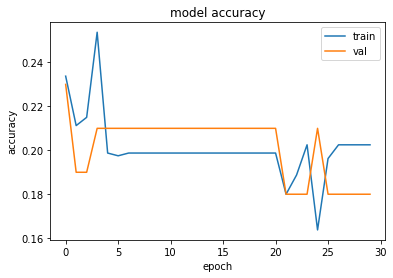

In [ ]:
print("Accuracy curves of model 1: ")

accuracy_plot(model_result)

In [ ]:
print("Testing Confusion matrix of model 1: ")
VGG_predict = custom_vgg_model.predict(x_test)
arg_predict = np.argmax(VGG_predict , axis=1)
cm1 = confusion_matrix(y_test,arg_predict)
cm1

Testing Confusion matrix of model 1: 
4/4 [==============================] - 0s 8ms/step


array([[ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0]])

In [ ]:
print("Training Confusion matrix of model 1: ")
VGG_predict = custom_vgg_model.predict(x_train)
arg_predict = np.argmax(VGG_predict , axis=1)
cm11 = confusion_matrix(y_train,arg_predict)
cm11

Training Confusion matrix of model 1: 
25/25 [==============================] - 0s 8ms/step


array([[  0,   0,   0, 161,   0],
       [  0,   0,   0, 159,   0],
       [  0,   0,   0, 157,   0],
       [  0,   0,   0, 162,   0],
       [  0,   0,   0, 161,   0]])

In [ ]:
print("Validation Confusion matrix of model 1: ")
VGG_predict = custom_vgg_model.predict(x_val)
arg_predict = np.argmax(VGG_predict , axis=1)
cm12 = confusion_matrix(y_val,arg_predict)
cm12

Validation Confusion matrix of model 1: 
4/4 [==============================] - 0s 7ms/step


array([[ 0,  0,  0, 19,  0],
       [ 0,  0,  0, 21,  0],
       [ 0,  0,  0, 23,  0],
       [ 0,  0,  0, 18,  0],
       [ 0,  0,  0, 19,  0]])

## Part 1b. Transfer Learning - Regression Reformulation

### Step 1
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

In [ ]:
model2 = VGG_model.layers[6].output
model2 = Flatten()(model2)
model2 = Dense(1024, activation = 'relu')(model2)
model2 = Dense(512, activation = 'relu')(model2)
model2 = Dense(256, activation = 'relu')(model2)
model2 = Dense(128, activation = 'relu')(model2)
model2 = Dense(32, activation = 'relu')(model2)



model2 = Dense(1)(model2)
output_layer = keras.layers.ReLU(max_value=5, threshold=0.0)(model2)

custom_vgg_model2 = Model(inputs=VGG_model.input, outputs=output_layer)

custom_vgg_model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mean_squared_error','accuracy']
)

model_result2 = custom_vgg_model2.fit(
    train_ds,
    epochs=30,
    batch_size=32,
    validation_data=(validation_ds)
    
    )


custom_vgg_model2.summary()

Epoch 1/30
25/25 [==============================] - 3s 80ms/step - loss: 10.3276 - mean_squared_error: 10.3276 - accuracy: 0.1937 - val_loss: 11.0900 - val_mean_squared_error: 11.0900 - val_accuracy: 0.2100
Epoch 2/30
25/25 [==============================] - 2s 73ms/step - loss: 10.9888 - mean_squared_error: 10.9888 - accuracy: 0.1988 - val_loss: 11.0900 - val_mean_squared_error: 11.0900 - val_accuracy: 0.2100
Epoch 3/30
25/25 [==============================] - 2s 73ms/step - loss: 10.9888 - mean_squared_error: 10.9888 - accuracy: 0.1988 - val_loss: 11.0900 - val_mean_squared_error: 11.0900 - val_accuracy: 0.2100
Epoch 4/30
25/25 [==============================] - 2s 75ms/step - loss: 10.9888 - mean_squared_error: 10.9888 - accuracy: 0.1988 - val_loss: 11.0900 - val_mean_squared_error: 11.0900 - val_accuracy: 0.2100
Epoch 5/30
25/25 [==============================] - 2s 76ms/step - loss: 10.9888 - mean_squared_error: 10.9888 - accuracy: 0.1988 - val_loss: 11.0900 - val_mean_squared_err

Loss curves of model 2: 


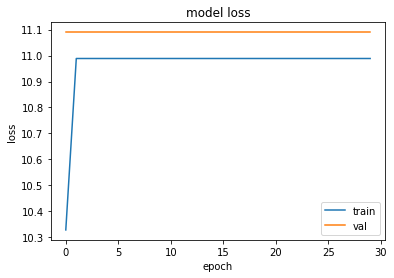

In [ ]:
print("Loss curves of model 2: ")
loss_plot(model_result2)

Loss curves of model 2: 


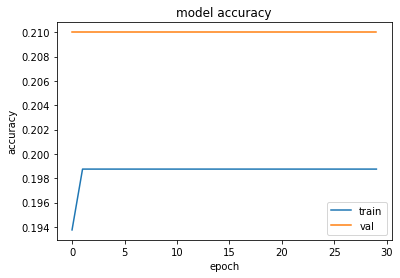

In [ ]:
print("Loss curves of model 2: ")
accuracy_plot(model_result2)

In [ ]:
print("Testing Confusion matrix of model 2: ")
VGG_predict = custom_vgg_model2.predict(x_test)
arg_predict = np.argmax(VGG_predict , axis=1)
cm2 = confusion_matrix(y_test,arg_predict)
cm2

Testing Confusion matrix of model 2: 
4/4 [==============================] - 0s 8ms/step


array([[20,  0,  0,  0,  0],
       [20,  0,  0,  0,  0],
       [20,  0,  0,  0,  0],
       [20,  0,  0,  0,  0],
       [20,  0,  0,  0,  0]])

In [ ]:
print("Training Confusion matrix of model 2: ")
VGG_predict = custom_vgg_model2.predict(x_train)
arg_predict = np.argmax(VGG_predict , axis=1)
cm21 = confusion_matrix(y_train,arg_predict)
cm21

Training Confusion matrix of model 2: 
25/25 [==============================] - 0s 8ms/step


array([[161,   0,   0,   0,   0],
       [159,   0,   0,   0,   0],
       [157,   0,   0,   0,   0],
       [162,   0,   0,   0,   0],
       [161,   0,   0,   0,   0]])

In [ ]:
print("Validation Confusion matrix of model 2: ")
VGG_predict = custom_vgg_model2.predict(x_val)
arg_predict = np.argmax(VGG_predict , axis=1)
cm22 = confusion_matrix(y_val,arg_predict)
cm22

Validation Confusion matrix of model 2: 
4/4 [==============================] - 0s 7ms/step


array([[19,  0,  0,  0,  0],
       [21,  0,  0,  0,  0],
       [23,  0,  0,  0,  0],
       [18,  0,  0,  0,  0],
       [19,  0,  0,  0,  0]])

Write your discussion here.

## Part 2. Improve your Model

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

In [ ]:
# Write your code here

In [ ]:
model3 = VGG_model.layers[6].output
model3 = Flatten()(model3)
model3 = Dense(1024, activation = 'relu')(custom_vgg)
model3 = BatchNormalization()(model3)
model3 = Dropout(0.5)(model3)
model3 = Dense(512, activation = 'relu')(custom_vgg)
model3 = BatchNormalization()(model3)
model3 = Dropout(0.3)(model3)
model3 = Dense(256, activation = 'relu')(custom_vgg)
model3 = BatchNormalization()(model3)
model3 = Dropout(0.2)(model3)
model3 = Dense(128, activation = 'relu')(custom_vgg)
model3 = BatchNormalization()(model3)
model3 = Dropout(0.1)(model3)
model3 = Dense(32, activation = 'relu')(custom_vgg)
model3 = BatchNormalization()(model3)
model3 = Dropout(0.05)(model3)



output_layer = Dense(len(class_names), activation='softmax')(custom_vgg)

model3 = Model(inputs=VGG_model.input, outputs=output_layer)

model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

model_result3 = model3.fit(
    train_ds,
    epochs=30,
    batch_size=32,
    validation_data=(validation_ds)
    
    )


model3.summary()

Epoch 1/30
25/25 [==============================] - 3s 85ms/step - loss: 1.6096 - accuracy: 0.1912 - val_loss: 1.6093 - val_accuracy: 0.2300
Epoch 2/30
25/25 [==============================] - 3s 76ms/step - loss: 1.6095 - accuracy: 0.1950 - val_loss: 1.6093 - val_accuracy: 0.2100
Epoch 3/30
25/25 [==============================] - 3s 78ms/step - loss: 1.6095 - accuracy: 0.1988 - val_loss: 1.6094 - val_accuracy: 0.2100
Epoch 4/30
25/25 [==============================] - 3s 77ms/step - loss: 1.6095 - accuracy: 0.1988 - val_loss: 1.6095 - val_accuracy: 0.1800
Epoch 5/30
25/25 [==============================] - 3s 100ms/step - loss: 1.6096 - accuracy: 0.1688 - val_loss: 1.6096 - val_accuracy: 0.1900
Epoch 6/30
25/25 [==============================] - 3s 75ms/step - loss: 1.6095 - accuracy: 0.1825 - val_loss: 1.6096 - val_accuracy: 0.1800
Epoch 7/30
25/25 [==============================] - 3s 77ms/step - loss: 1.6095 - accuracy: 0.1813 - val_loss: 1.6096 - val_accuracy: 0.1800
Epoch 8/30
2

Loss curves of model 3: 


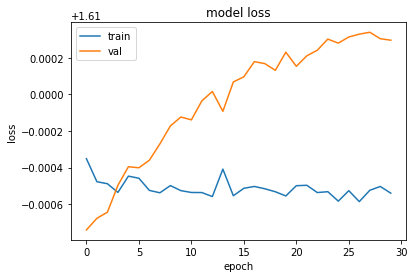

In [ ]:
print("Loss curves of model 3: ")
loss_plot(model_result3)

Accuracy curves of model 3: 


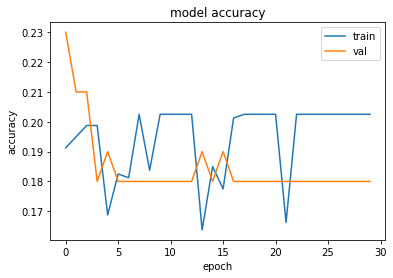

In [ ]:
print("Accuracy curves of model 3: ")
accuracy_plot(model_result3)

In [ ]:
print("Testing Confusion matrix of model 3: ")
VGG_predict = model3.predict(x_test)
arg_predict = np.argmax(VGG_predict , axis=1)
cm3 = confusion_matrix(y_test,arg_predict)
cm3

Testing Confusion matrix of model 3: 
4/4 [==============================] - 0s 8ms/step


array([[ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0]])

In [ ]:
print("Training Confusion matrix of model 3: ")
VGG_predict = model3.predict(x_train)
arg_predict = np.argmax(VGG_predict , axis=1)
cm31 = confusion_matrix(y_train,arg_predict)
cm31

Training Confusion matrix of model 3: 
25/25 [==============================] - 0s 9ms/step


array([[  0,   0,   0, 161,   0],
       [  0,   0,   0, 159,   0],
       [  0,   0,   0, 157,   0],
       [  0,   0,   0, 162,   0],
       [  0,   0,   0, 161,   0]])

In [ ]:
print("Validation Confusion matrix of model 3: ")
VGG_predict = model3.predict(x_val)
arg_predict = np.argmax(VGG_predict , axis=1)
cm32 = confusion_matrix(y_val,arg_predict)
cm32

Validation Confusion matrix of model 3: 
4/4 [==============================] - 0s 8ms/step


array([[ 0,  0,  0, 19,  0],
       [ 0,  0,  0, 21,  0],
       [ 0,  0,  0, 23,  0],
       [ 0,  0,  0, 18,  0],
       [ 0,  0,  0, 19,  0]])

In [ ]:
model4 = VGG_model.layers[6].output
model4 = Flatten()(model4)
model4 = Dense(1024, activation = 'relu')(custom_vgg)
model4 = BatchNormalization()(model4)
model4 = Dropout(0.5)(model4)
model4 = Dense(512, activation = 'relu')(custom_vgg)
model4 = BatchNormalization()(model4)
model4 = Dropout(0.3)(model4)
model4 = Dense(256, activation = 'relu')(custom_vgg)
model4 = BatchNormalization()(model4)
model4 = Dropout(0.2)(model4)
model4 = Dense(128, activation = 'relu')(custom_vgg)
model4 = BatchNormalization()(model4)
model4 = Dropout(0.1)(model4)
model4 = Dense(32, activation = 'relu')(custom_vgg)
model4 = BatchNormalization()(model4)
model4 = Dropout(0.05)(model4)



output_layer = Dense(len(class_names), activation='softmax')(custom_vgg)

model4 = Model(inputs=VGG_model.input, outputs=output_layer)

model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)




model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
train_aug =ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=30, width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
train_aug.fit(x_train)
train_aug_output = train_aug.flow(x_train,y_train,batch_size=180)
Augmentation_results = model4.fit(
    train_aug_output,
    epochs=30,
    batch_size=32,
    validation_data=(validation_ds)
    )

Epoch 1/30
5/5 [==============================] - 3s 333ms/step - loss: 1.6095 - accuracy: 0.1775 - val_loss: 1.6094 - val_accuracy: 0.2100
Epoch 2/30
5/5 [==============================] - 1s 240ms/step - loss: 1.6095 - accuracy: 0.1875 - val_loss: 1.6094 - val_accuracy: 0.1900
Epoch 3/30
5/5 [==============================] - 1s 255ms/step - loss: 1.6095 - accuracy: 0.2013 - val_loss: 1.6095 - val_accuracy: 0.1900
Epoch 4/30
5/5 [==============================] - 1s 250ms/step - loss: 1.6094 - accuracy: 0.2013 - val_loss: 1.6095 - val_accuracy: 0.1900
Epoch 5/30
5/5 [==============================] - 1s 248ms/step - loss: 1.6095 - accuracy: 0.2013 - val_loss: 1.6096 - val_accuracy: 0.1900
Epoch 6/30
5/5 [==============================] - 1s 279ms/step - loss: 1.6094 - accuracy: 0.2013 - val_loss: 1.6096 - val_accuracy: 0.1900
Epoch 7/30
5/5 [==============================] - 1s 245ms/step - loss: 1.6094 - accuracy: 0.2013 - val_loss: 1.6097 - val_accuracy: 0.1900
Epoch 8/30
5/5 [====

Loss curves of model 4: 


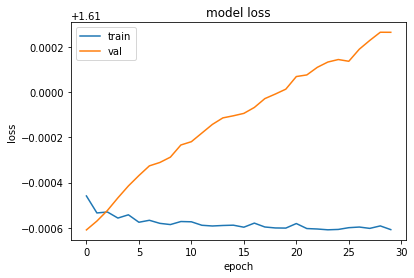

In [ ]:
print("Loss curves of model 4: ")
loss_plot(Augmentation_results)

Loss curves of model 4: 


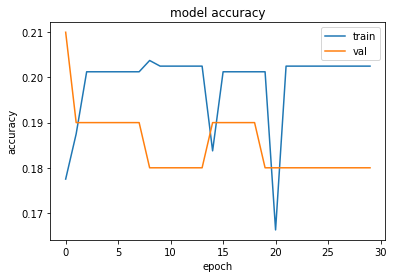

In [ ]:
print("Loss curves of model 4: ")
accuracy_plot(Augmentation_results)

In [ ]:
print("Testing Confusion matrix of model 3: ")
VGG_predict = model4.predict(x_test)
arg_predict = np.argmax(VGG_predict , axis=1)
cm4 = confusion_matrix(y_test,arg_predict)
cm4

Testing Confusion matrix of model 3: 
4/4 [==============================] - 0s 9ms/step


array([[ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  0, 20,  0]])

In [ ]:
VGG_predict = model4.predict(x_train)
arg_predict = np.argmax(VGG_predict , axis=1)
cm41 = confusion_matrix(y_train,arg_predict)
cm41

25/25 [==============================] - 0s 9ms/step


array([[  0,   0,   0, 161,   0],
       [  0,   0,   0, 159,   0],
       [  0,   0,   0, 157,   0],
       [  0,   0,   0, 162,   0],
       [  0,   0,   0, 161,   0]])

In [ ]:
VGG_predict = model4.predict(x_val)
arg_predict = np.argmax(VGG_predict , axis=1)
cm42 = confusion_matrix(y_val,arg_predict)
cm42

4/4 [==============================] - 0s 7ms/step


array([[ 0,  0,  0, 19,  0],
       [ 0,  0,  0, 21,  0],
       [ 0,  0,  0, 23,  0],
       [ 0,  0,  0, 18,  0],
       [ 0,  0,  0, 19,  0]])

Discussion:

Before augmentation, according to the confusion matrices, the model was able to detect different classes but it needs fine tuning without data augmentation. Nevertheless, the validation loss and accuracy after data augmentation were fixed. Generally, the model without data augmentation is better. It was recognized that the models get stuck in a local minimum as though reaching around 20% in both training and testing, while in other runs it reached 90%+ training and 40%+ testing.

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.